<center>
<img src="../imgs/ods_stickers.jpg">
    
## Открытый курс по машинному обучению
Автор материала: аналитик-разработчик в команде Яндекс.Метрики Мария Мансурова. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

#### <center>К [статье](https://habrahabr.ru/company/ods/blog/323730/) на Хабре "Предсказываем будущее с помощью библиотеки Facebook Prophet"

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd

from plotly import __version__
print(__version__) # need 1.9.0 or greater
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests
import pandas as pd

init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)
    
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

4.2.1


## Загрузка и предобработка данных
Данные [соревнования](https://inclass.kaggle.com/c/howpop-habrahabr-favs-lognorm) по прогнозу популярности статьи на Хабрахабре.

In [2]:
habr_df = pd.read_csv('../data/howpop_train.csv.zip')

In [3]:
habr_df['published'] = pd.to_datetime(habr_df.published)
habr_df = habr_df[['published', 'url']]
habr_df = habr_df.drop_duplicates()

In [4]:
aggr_habr_df = habr_df.groupby('published')[['url']].count()
aggr_habr_df.columns = ['posts']

In [5]:
aggr_habr_df = aggr_habr_df.resample('D').apply(sum)
plotly_df(aggr_habr_df.resample('W').apply(sum), 
          title = 'Опубликованные посты на Хабрахабре')

## Построение прогноза Prophet

In [6]:
# pip install pystan
# pip install fbprophet
from fbprophet import Prophet

In [7]:
predictions = 30

df = aggr_habr_df.reset_index()
df.columns = ['ds', 'y']
df.tail()

,ds,y
3222,2016-10-27,58
3223,2016-10-28,53
3224,2016-10-29,14
3225,2016-10-30,27
3226,2016-10-31,80


In [8]:
train_df = df[:-predictions]

In [9]:
m = Prophet()
m.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [10]:
future = m.make_future_dataframe(periods=30)
future.tail()

,ds
3222,2016-10-27
3223,2016-10-28
3224,2016-10-29
3225,2016-10-30
3226,2016-10-31


In [11]:
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3222,2016-10-27,56.770482,52.897062,81.923193,56.770482,56.770482,10.729512,10.729512,10.729512,8.474033,8.474033,8.474033,2.255479,2.255479,2.255479,0.0,0.0,0.0,67.499994
3223,2016-10-28,56.767234,49.333718,78.685737,56.767234,56.767234,6.929765,6.929765,6.929765,4.653241,4.653241,4.653241,2.276523,2.276523,2.276523,0.0,0.0,0.0,63.696998
3224,2016-10-29,56.763985,20.948744,49.789188,56.763971,56.764745,-21.048023,-21.048023,-21.048023,-23.329583,-23.329583,-23.329583,2.281560,2.281560,2.281560,0.0,0.0,0.0,35.715962
3225,2016-10-30,56.760737,24.099035,53.373930,56.759812,56.762818,-18.619574,-18.619574,-18.619574,-20.890730,-20.890730,-20.890730,2.271156,2.271156,2.271156,0.0,0.0,0.0,38.141163
3226,2016-10-31,56.757488,54.454731,83.091741,56.755015,56.760011,11.833145,11.833145,11.833145,9.586917,9.586917,9.586917,2.246228,2.246228,2.246228,0.0,0.0,0.0,68.590633


In [12]:
print(', '.join(forecast.columns))

ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, weekly, weekly_lower, weekly_upper, yearly, yearly_lower, yearly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


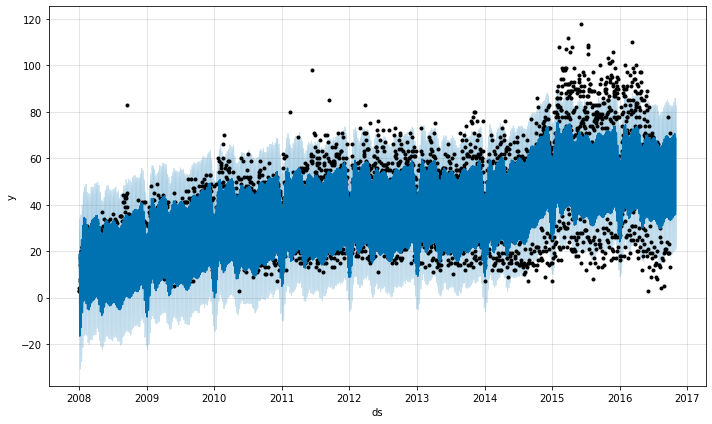

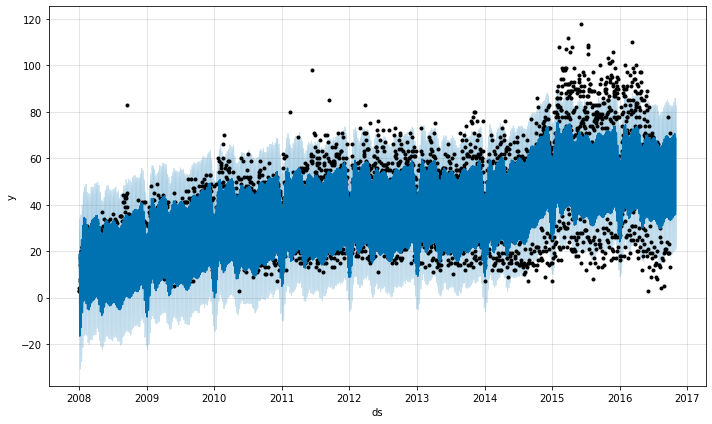

In [16]:
m.plot(forecast)

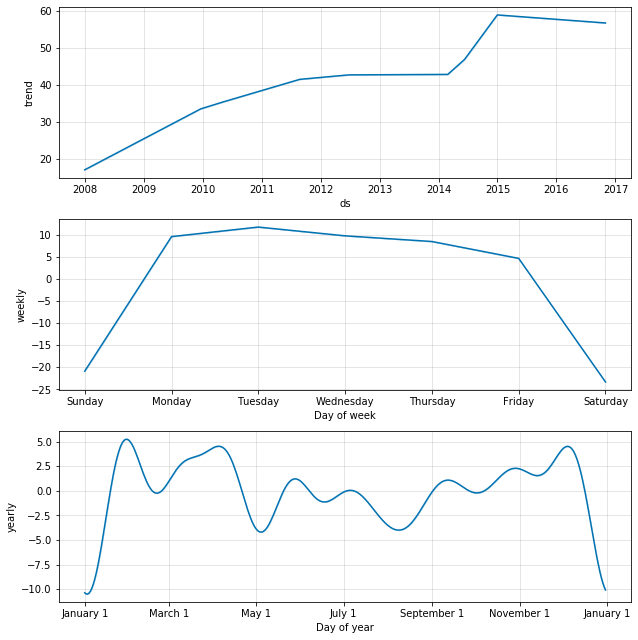

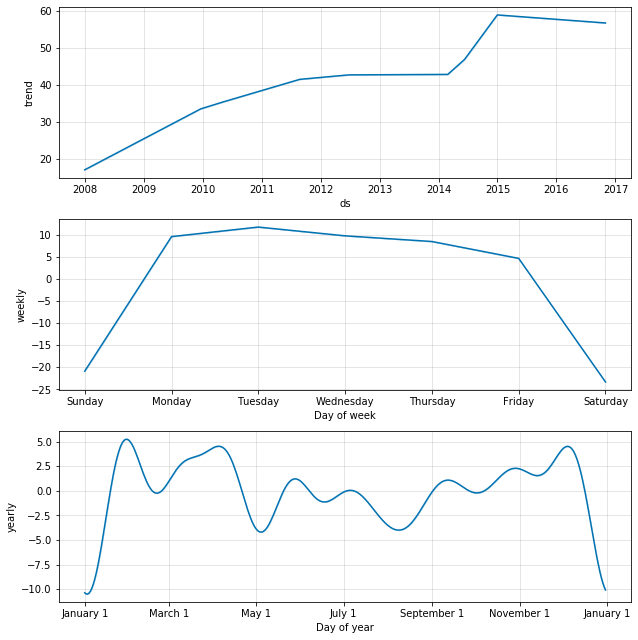

In [14]:
m.plot_components(forecast)

## Оценка качества Prophet

In [17]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

In [18]:
import numpy as np
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
np.mean(abs(cmp_df[-predictions:]['p'])), np.mean(abs(cmp_df[-predictions:]['e']))

(37.716196957738504, 10.729962907493677)

## Прогноз с BoxCox

In [19]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda * y + 1) / lmbda))

In [20]:
train_df2 = train_df.copy().fillna(14)
train_df2 = train_df2.set_index('ds')
train_df2['y'], lmbda_prophet = stats.boxcox([1 if x==0 else x for x in train_df2['y']])

train_df2.reset_index(inplace=True)

m2 = Prophet()
m2.fit(train_df2)
future2 = m2.make_future_dataframe(periods=30)

forecast2 = m2.predict(future2)
forecast2['yhat'] = invboxcox(forecast2.yhat, lmbda_prophet)
forecast2['yhat_lower'] = invboxcox(forecast2.yhat_lower, lmbda_prophet)
forecast2['yhat_upper'] = invboxcox(forecast2.yhat_upper, lmbda_prophet)

cmp_df2 = forecast2.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

cmp_df2['e'] = cmp_df2['y'] - cmp_df2['yhat']
cmp_df2['p'] = 100*cmp_df2['e']/cmp_df2['y']
np.mean(abs(cmp_df2[-predictions:]['p'])), np.mean(abs(cmp_df2[-predictions:]['e']))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(26.215349165938377, 8.303699316488004)

## Визуализация результатов

In [21]:
def show_forecast(cmp_df, num_predictions, num_values):
    upper_bound = go.Scatter(
        name='Upper Bound',
        x=cmp_df.tail(num_predictions).index,
        y=cmp_df.tail(num_predictions).yhat_upper,
        mode='lines',
        marker=dict(color='white'),
        line=dict(width=0),
        fillcolor='rgb(68, 68, 68)',)
#         fill='tonexty')

    forecast = go.Scatter(
        name='Prediction',
        x=cmp_df.tail(predictions).index,
        y=cmp_df.tail(predictions).yhat,
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    )

    lower_bound = go.Scatter(
        name='Lower Bound',
        x=cmp_df.tail(num_predictions).index,
        y=cmp_df.tail(num_predictions).yhat_lower,
        marker=dict(color='white'),
        line=dict(width=0),
        mode='lines')

    fact = go.Scatter(
        name='Fact',
        x=cmp_df.tail(num_values).index,
        y=cmp_df.tail(num_values).y,
        marker=dict(color="red"),
        mode='lines',
    )

    # Trace order can be important
    # with continuous error bars
    data = [lower_bound, upper_bound, forecast, fact]

    layout = go.Layout(
        yaxis=dict(title='Посты'),
        title='Опубликованные посты на Хабрахабре',
        showlegend = False)

    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

In [22]:
show_forecast(cmp_df, predictions, 200)

##  Сравнение с ARIMA моделью

In [23]:
train_df = train_df.set_index('ds')

<Figure size 1800x720 with 0 Axes>

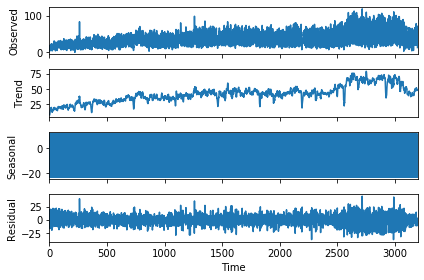

Критерий Дики-Фуллера: p=0.040320


In [24]:
plt.figure(figsize=(25,10))
res = sm.tsa.seasonal_decompose(train_df['y'].values, freq=7)
res.plot()
plt.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df['y'])[1])

In [25]:
train_df.index = pd.to_datetime(train_df.index)

Оптимальный параметр преобразования Бокса-Кокса: 0.423912
Критерий Дики-Фуллера: p=0.040320


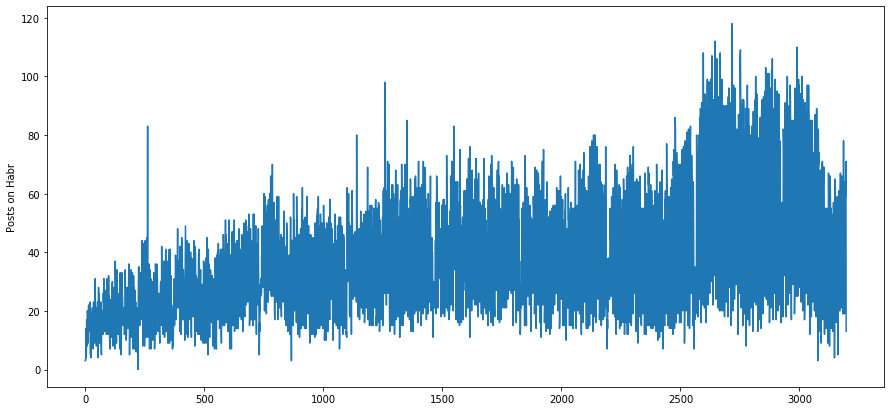

In [26]:
train_df['y_box'], lmbda = stats.boxcox([1 if x == 0 else x for x in train_df['y']])
plt.figure(figsize=(15,7))
plt.plot(train_df['y'].values)
plt.ylabel(u'Posts on Habr')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df['y'])[1])

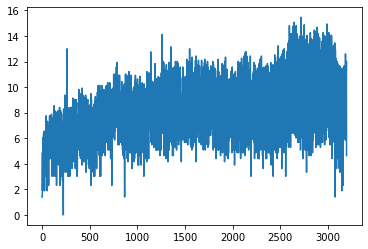

In [27]:
plt.plot(train_df['y_box'].values)


Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

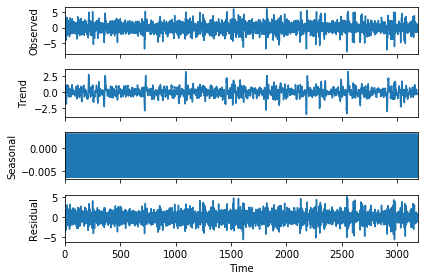

In [28]:
train_df['y_box_diff'] = train_df.y_box - train_df.y_box.shift(7)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(train_df.y_box_diff[12:].values, freq=7).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df.y_box_diff[8:])[1])

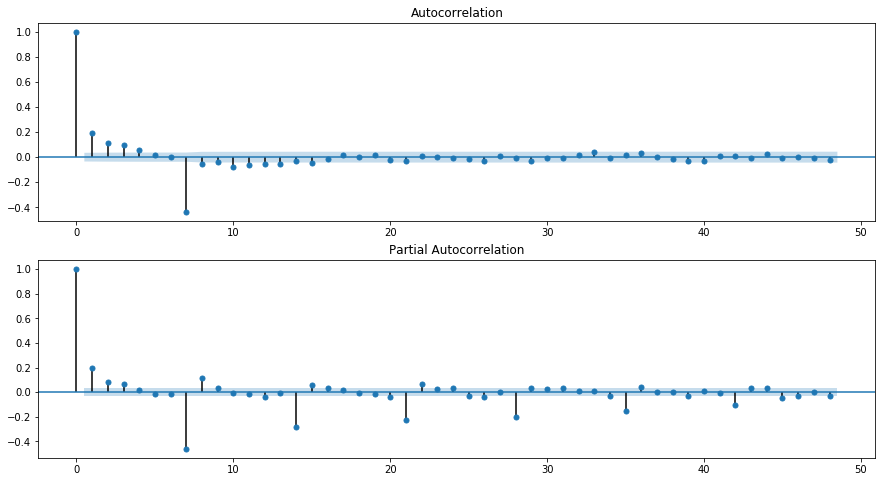

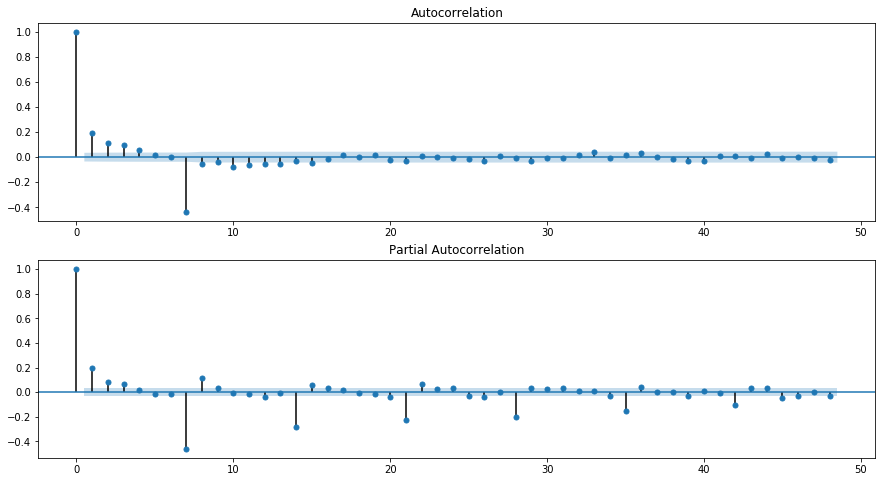

In [29]:
plt.figure(figsize=(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(train_df.y_box_diff[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(train_df.y_box_diff[13:].values.squeeze(), lags=48, ax=ax)

Начальные приближения: Q = 1, q = 4, P = 6, p = 3

(Но мы построим модель на самых простых параметрах, так как много перебирать - вычислительно тяжело).

In [30]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 2)
s=7

In [31]:
from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [32]:
%%time
results = []
best_aic = float("inf")



for param in parameters_list:
    print(param)
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(train_df.y_box, 
                                              order=(param[0], d, param[1]), 
                                              seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

(0, 0, 0, 0)
(0, 0, 0, 1)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



(0, 0, 1, 0)
(0, 0, 1, 1)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



(0, 1, 0, 0)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



(0, 1, 0, 1)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



(0, 1, 1, 0)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



(0, 1, 1, 1)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



(1, 0, 0, 0)
(1, 0, 0, 1)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



(1, 0, 1, 0)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



(1, 0, 1, 1)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



(1, 1, 0, 0)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



(1, 1, 0, 1)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



(1, 1, 1, 0)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



(1, 1, 1, 1)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 27.5 s, sys: 1.44 s, total: 28.9 s
Wall time: 14.9 s


In [33]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters           aic
15  (1, 1, 1, 1)   9828.586841
13  (1, 1, 0, 1)   9835.156968
7   (0, 1, 1, 1)   9910.224111
5   (0, 1, 0, 1)   9911.233325
11  (1, 0, 1, 1)  10564.199038


In [34]:
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                             y_box   No. Observations:                 3197
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -4909.293
Date:                           Mon, 11 Nov 2019   AIC                           9828.587
Time:                                   18:37:45   BIC                           9858.924
Sample:                               01-01-2008   HQIC                          9839.465
                                    - 10-01-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2268      0.015     14.797      0.000       0.197       0.257
ma.L1         -0.9334      0.007   -139.948

Критерий Стьюдента: p=0.243513
Критерий Дики-Фуллера: p=0.000000


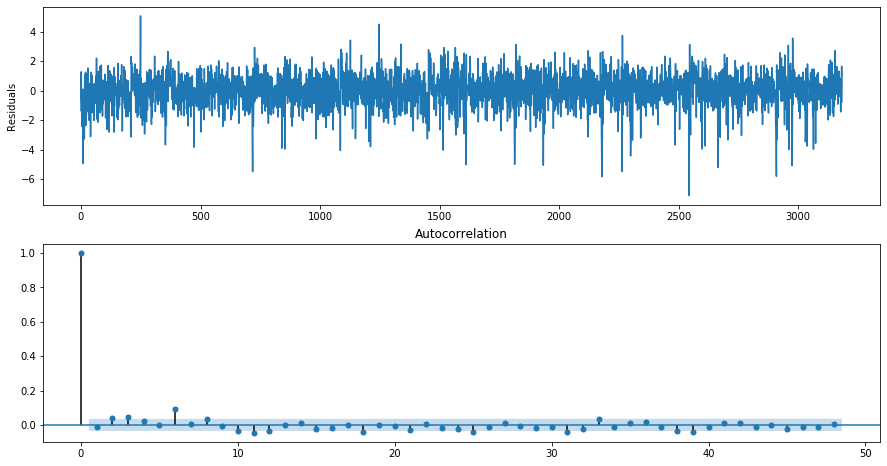

In [35]:
plt.figure(figsize=(15,8))
plt.subplot(211)
plt.plot(best_model.resid[13:].values)
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

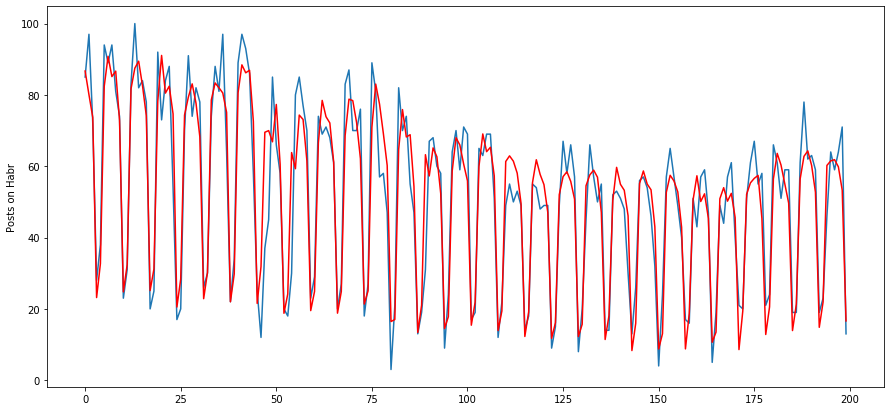

In [36]:
train_df['arima_model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
plt.plot(train_df['y'].tail(200).values)
plt.plot(train_df.arima_model[13:].tail(200).values, color='r')
plt.ylabel('Posts on Habr');

In [37]:
import datetime

In [38]:
arima_df = train_df2.set_index('ds')[['y']]

date_list = [pd.datetime.strptime("2016-10-01", "%Y-%m-%d") +
             datetime.timedelta(days=x) for x in range(predictions+1)]

future = pd.DataFrame(index=date_list, columns= arima_df.columns)
arima_df = pd.concat([arima_df, future])
arima_df['forecast'] = invboxcox(best_model.predict(start=train_df.shape[0],
                                                    end=train_df.shape[0]+predictions-1), lmbda)

In [39]:
cmp_df.head()

,yhat,yhat_lower,yhat_upper,y,e,p
ds,,,,,,
2008-01-01,18.549751,4.038246,34.095911,3,-15.549751,-518.325046
2008-01-02,16.391785,1.395314,30.440586,3,-13.391785,-446.392827
2008-01-03,15.036477,-0.446047,29.689713,4,-11.036477,-275.911922
2008-01-04,11.254027,-2.825677,26.803768,14,2.745973,19.614096
2008-01-05,-16.582812,-30.559018,-1.596684,4,20.582812,514.570297


In [40]:
cmp_df = cmp_df.join(arima_df[['forecast']])

In [41]:
import numpy as np
cmp_df['e_arima'] = cmp_df['y'] - cmp_df['forecast']
cmp_df['p_arima'] = 100*cmp_df['e_arima']/cmp_df['y']

In [42]:
np.mean(abs(cmp_df[-predictions:]['p_arima'])), np.mean(abs(cmp_df[-predictions:]['e_arima']))

(13.961983344460668, 6.03896300260183)

In [43]:
num_values = 200

forecast = go.Scatter(
    name='Prophet',
    x=cmp_df.tail(predictions).index,
    y=cmp_df.tail(predictions).yhat,
    mode='lines',
    line=dict(color='rgb(31, 119, 180)'),
)


fact = go.Scatter(
    name='Fact',
    x=cmp_df.tail(num_values).index,
    y=cmp_df.tail(num_values).y,
    marker=dict(color="red"),
    mode='lines',
)

arima = go.Scatter(
    name='ARIMA',
    x=cmp_df.tail(predictions).index,
    y=cmp_df.tail(predictions).forecast,
    mode='lines'
)

# Trace order can be important
# with continuous error bars
data = [forecast, fact, arima]

layout = go.Layout(
    yaxis=dict(title='Посты'),
    title='Опубликованные посты на Хабрахабре',
    showlegend = True)

fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)